# Classification of beats using MLP and SVC models and beat holdout method

In [10]:
from platform import python_version
print(python_version())

3.10.10


In [6]:
!pip3 install --upgrade pip

In [14]:
!pip3 install --user tensorflow==2.2

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0rc0)
ERROR: No matching distribution found for tensorflow==2.2


In [17]:
!pip3 install --user tensorflow==2.8

  Using cached tensorflow-2.8.0-cp310-cp310-win_amd64.whl (438.0 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# Imports:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
length = 277

### Load the holdout beats data and one-hot encode the heart beat classes

In [3]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data, and one-hot encode Y:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]
y_train = train_values[:,-2]
y_test = test_values[:,-2]

# One-hot encode Y:
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)

Loading  ../mimic3-code-main/module2_week1/train_beats.csv
Loading  ../mimic3-code-main/module2_week1/test_beats.csv
(31912, 277)
(37863, 277)


### Create show results function

In [14]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score_macro = f1_score(test, pred, average='macro') 
    f1score_micro = f1_score(test, pred, average='micro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score macro : {}".format(f1score_macro))
    print("f1score micro : {}".format(f1score_micro))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score_macro,3), 
            round(f1score_micro, 3), cm)

### Build the multi-layer perceptron architecture and train the model

In [32]:
# Build a multi-layer perceptron:
def getModel():
    mlpmodel = Sequential()
    mlpmodel.add(Dense(100, activation = 'relu'))
    mlpmodel.add(Dense(9, activation = 'softmax'))
    return mlpmodel

mlpmodel = getModel()
mlpmodel.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy())

mlpmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               27600     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909       
Total params: 28,509
Trainable params: 28,509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mlphistory = mlpmodel.fit(X_train, y_train1, validation_split = 0.2, epochs = 100, verbose = 0)

In [7]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(mlpmodel, 'mlpmodel_module2.h5')

### NNMLP Performance Metrics

In [15]:
# Performance metrics
pred = mlpmodel.predict(X_test)
nnmlp_results = showResults(np.argmax(y_test1, axis = 1), np.argmax(pred, axis = 1), 'NNMLP')

Accuracy  : 0.9516414441539234
Precision : 0.780751183514714
Recall : 0.9509532596614665
f1score macro : 0.8405461336913103
f1score micro : 0.9516414441539234


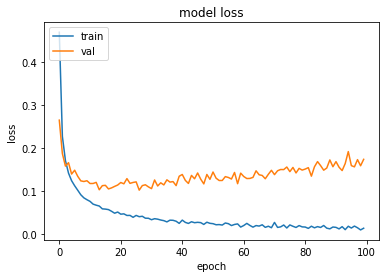

In [39]:
fig = plt.figure()
plt.plot(mlphistory.history['loss'])
plt.plot(mlphistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig.savefig('mlp_holdout_beats_loss_and_cm_a.jpg', dpi = 400)

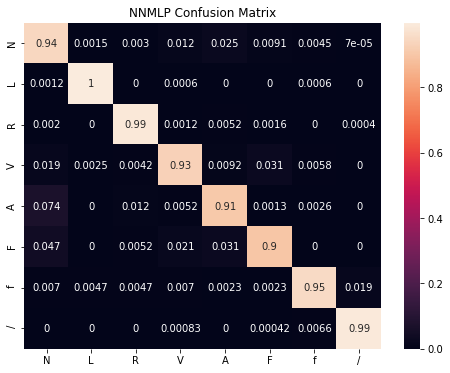

In [13]:
categories=['N','L','R','V','A','F','f','/']
fig = plt.figure(figsize=(8,6))
cm = confusion_matrix(np.argmax(y_test1, axis = 1), np.argmax(pred, axis = 1), normalize='true')
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)
plt.title('NNMLP Confusion Matrix')
plt.show()
#fig.savefig('mlp_holdout_beats_loss_and_cm_b.jpg', dpi = 400)

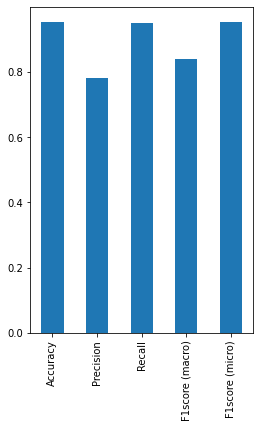

In [42]:
# performance metrics
NNMLP_results = pd.DataFrame(data=(nnmlp_results),index=('Model','Accuracy','Precision','Recall','F1score (macro)', 'F1score (micro)','CM'))
fig = plt.figure(figsize=(4,6))
NNMLP_results[0][1:6].plot(kind='bar')
plt.show()
fig.tight_layout()
fig.savefig('mlp_holdout_beats_metrics.jpg', dpi = 400)

### Save NNMLP model, model weights and results


In [25]:
if not os.path.exists('./model_weights/'):
    os.mkdir('model_weights')
mlpmodel.save('./model_weights/NNMLP_model_beats')

if not os.path.exists('./model_results/'):
    os.mkdir('model_results')
NNMLP_results.to_csv('./model_results/nnmlp_beats_results.csv', encoding='utf-8', index=False)

INFO:tensorflow:Assets written to: ./model_weights/NNMLP_model_beats\assets


### Initialize and train an SVC model

In [26]:
#support vector classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svc_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc_clf.fit(X_train, y_train)
print('Support Vector Results')
y_pred_svc = svc_clf.predict(X_test)
print(svc_clf.score(X_test,y_test))

Support Vector Results
0.9483928901566173


### SVC Performance metrics

In [27]:
# performance metrics
svc_results = showResults(y_test, y_pred_svc, 'SVC')

Accuracy  : 0.9483928901566173
Precision : 0.7776176240756051
Recall : 0.9556225021951151
f1score macro : 0.8295184273339967
f1score micro : 0.9483928901566173


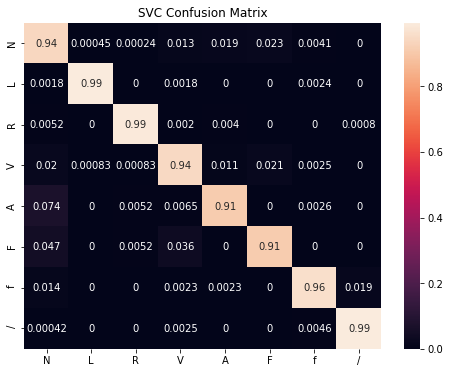

In [28]:
# performance metrics
categories=['N','L','R','V','A','F','f','/']

fig = plt.figure(figsize=(8,6))

cm = confusion_matrix(y_test, y_pred_svc, normalize='true')
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)
plt.title('SVC Confusion Matrix')
plt.show()
fig.savefig('svc_holdout_beats_confusion_matrix_and_metrics_a.jpg', dpi = 400)

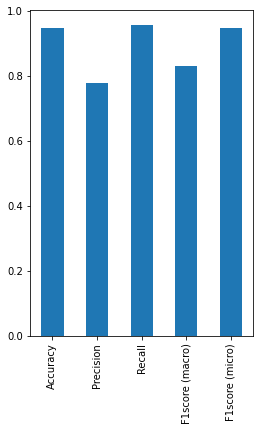

In [43]:
# performance metrics
SVC_results = pd.DataFrame(data=(svc_results),index=('Model','Accuracy','Precision','Recall','F1score (macro)', 
                                                     'F1score (micro)','CM'))
fig = plt.figure(figsize=(4,6))
SVC_results[0][1:6].plot(kind='bar')
plt.show()
fig.tight_layout()
fig.savefig('svc_holdout_beats_confusion_matrix_and_metrics_b.jpg', dpi = 400)

### Save SVC model, model weights and results


In [30]:
# Save to file in the current working directory
pkl_svc = "./model_weights/SVC_model_beats.pkl"
with open(pkl_svc, 'wb') as file:
    pickle.dump(svc_clf, file)

# Load from file
# with open(pkl_svc, 'rb') as file:
#     pickle_svc = pickle.load(file)

print(SVC_results)
SVC_results.to_csv('./model_results/svc_beats_results.csv', encoding='utf-8', index=False)

                                                                 0
Model                                                          SVC
Accuracy                                                     0.948
Precision                                                    0.778
Recall                                                       0.956
F1score (macro)                                               0.83
F1score (micro)                                              0.948
CM               [[26975, 13, 7, 369, 556, 666, 117, 0], [3, 16...
